In [7]:
from freealg import FreeForm
from freealg.distributions import MarchenkoPastur, Wigner, Wachter, Meixner, KestenMcKay
import numpy as np
import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
import texplot

latex = True
ext = '.pdf'

In [8]:
# ================
# decomporess plot
# ================

def decompress_plot(eig, x, ff, family, save_filename, ylim=None):
    
    sizes = list(eig.size * 2**numpy.arange(0, 6))
    sizes = [int(size) for size in sizes]

    rhos_pred, _ = ff.decompress(sizes, x=x, method='newton', max_iter=500,
                                 step_size=0.1, tolerance=1e-4, plot=False,
                                 latex=False, save=False,
                                 plot_diagnostics=True)

    lw = 1.5
    
    num_plots = len(sizes)
    cmap = plt.get_cmap('gist_heat')
    colors = [cmap(i/(num_plots + 2)) for i in range(num_plots + 1)][1:]
    
    with texplot.theme(use_latex=latex):
        
        fig, ax = plt.subplots(figsize=(10, 3.1), ncols=3, sharey=True)
     
        ax[0].plot(x, rhos_pred[0], linewidth=lw, color='black', label='Density Estimate')
        ax[0].hist(eig, bins=25, density=True, color='lightsteelblue', alpha=0.8,
                   edgecolor='none', label='Empirical Spectrum', rasterized=True)
        ax[0].set_title('(a) Initial Empirical Density ($n=1$K)')
    
        for i in range(0, len(sizes)):
            ax[1].plot(x, rhos_pred[i], linewidth=lw, color=colors[i],
                       label=f'$n = {{{sizes[i]//1000}}}$K')
            
        ax[1].set_title('(b) Free Decompression')
    
        mp2 = family(sizes[-1])
        mprho = mp2.density(x, plot=False)
    
        ax[2].plot(x, mprho, linewidth=lw, color='black',
                   label=r'Benchmark Density (Exact)')
        ax[2].plot(x, rhos_pred[-1], linewidth=lw, color=colors[-1],
                   label='Free Decompression Solution')
        ax[2].set_title(r'(c) Final Empirical Density ($n=32$K)')
    
        for i in range(len(ax)):
            ax[i].legend(fontsize='x-small')
            ax[i].set_xlabel(r'$\lambda$')
            if ylim is not None:
                ax[i].set_ylim(ylim)
            ax[i].set_xlim([x[0], x[-1]])
            
        ax[0].set_ylabel(r'Density $\rho(\lambda)$')
    
        for i in range(1, len(ax)):
            ax[i].tick_params(left=False, labelleft=False)
    
        plt.tight_layout()
        texplot.show_or_save_plot(plt, default_filename=save_filename,
                                  transparent_background=True, dpi=200,
                                  show_and_save=True, verbose=True)


### Marchenko-Pastur

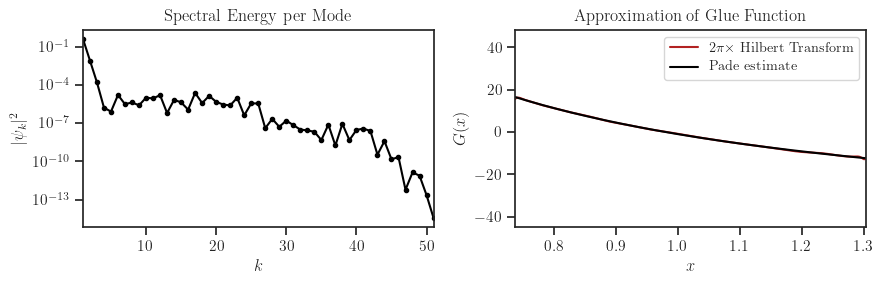

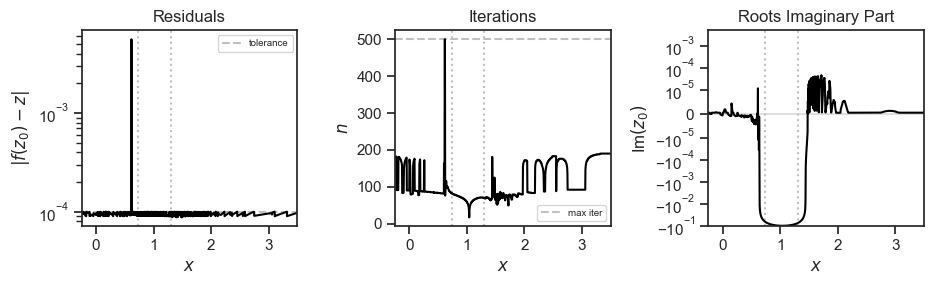

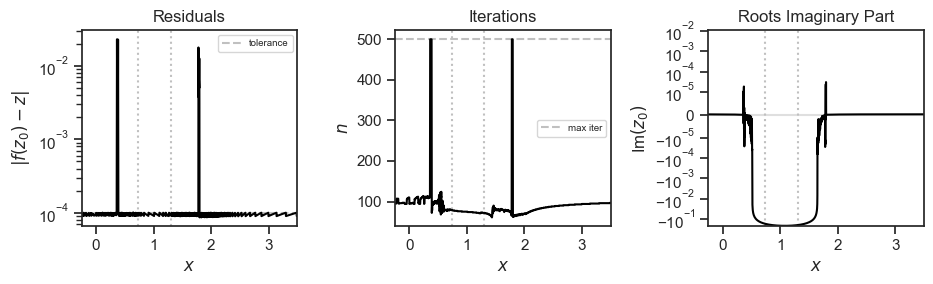

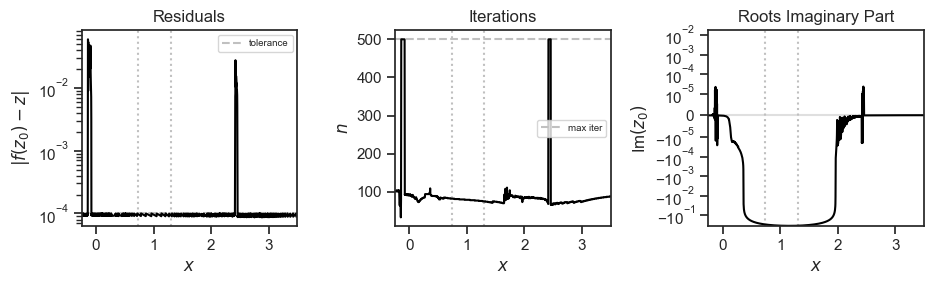

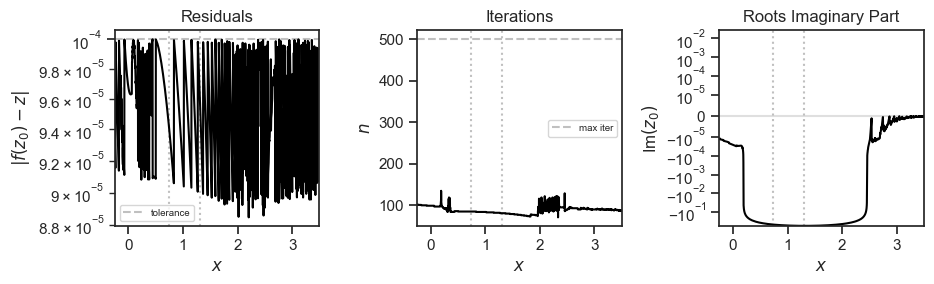

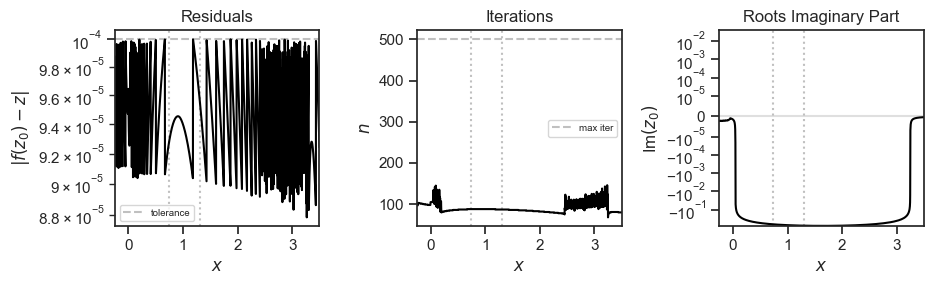

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_mp.pdf".


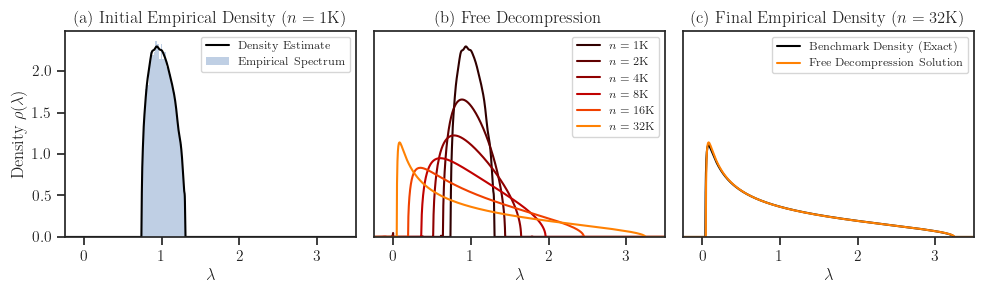

In [9]:
c = 1/50
mp = MarchenkoPastur(c)
A = mp.matrix(1000, seed=1001)
eig = np.linalg.eigvalsh(A)
#eig = mp.sample(1000)

ff = FreeForm(eig, support=(mp.lam_m, mp.lam_p), delta=1e-6)
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, continuation='pade', pade_p=0, pade_q=1,
             odd_side='left', pade_reg=0, optimizer='ls',
             plot=True, latex=latex, save=False)

family = lambda n: MarchenkoPastur((n/1000)/50)
x = np.linspace(-0.25, 3.5, 2000)
save_filename = 'flow_mp' + ext

decompress_plot(eig, x, ff, family, save_filename)

### Wigner

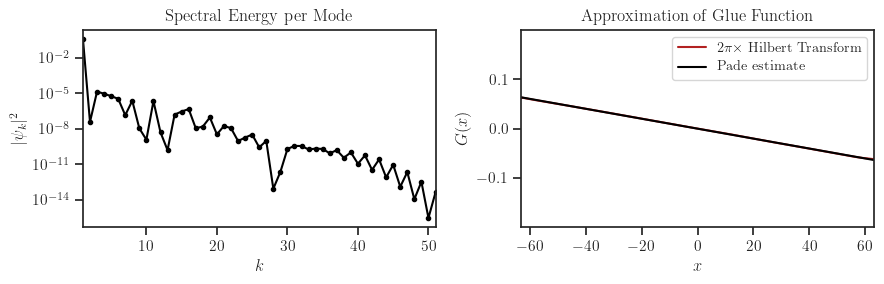

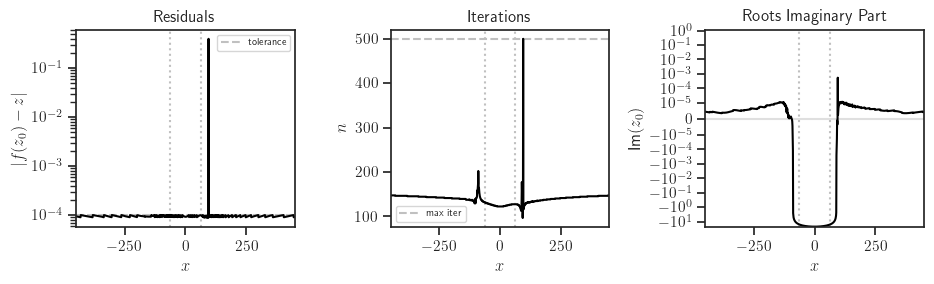

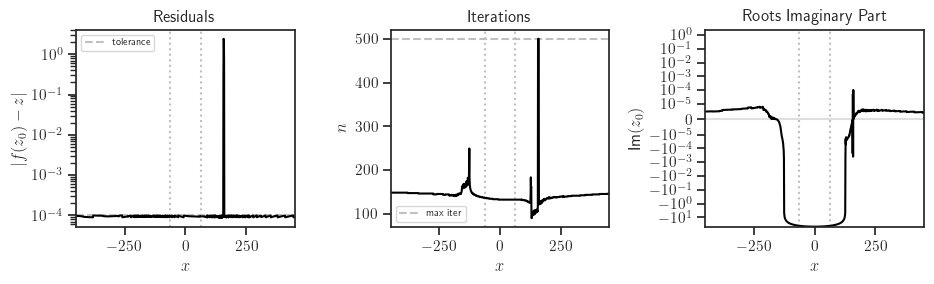

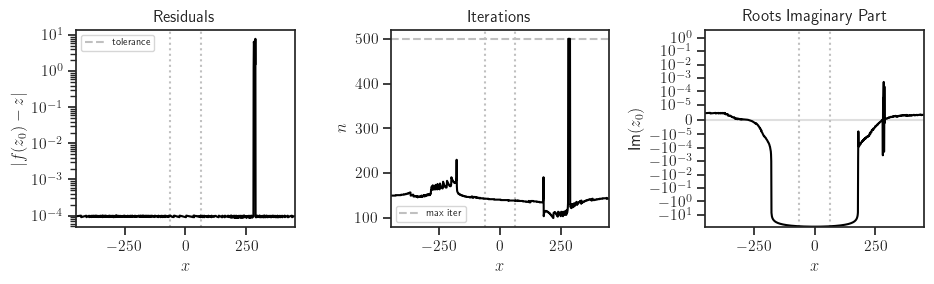

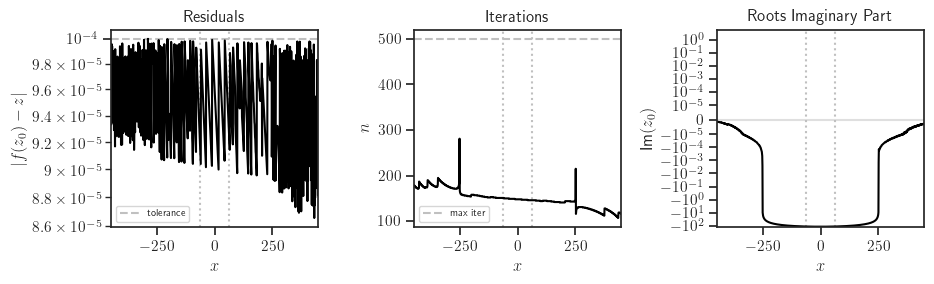

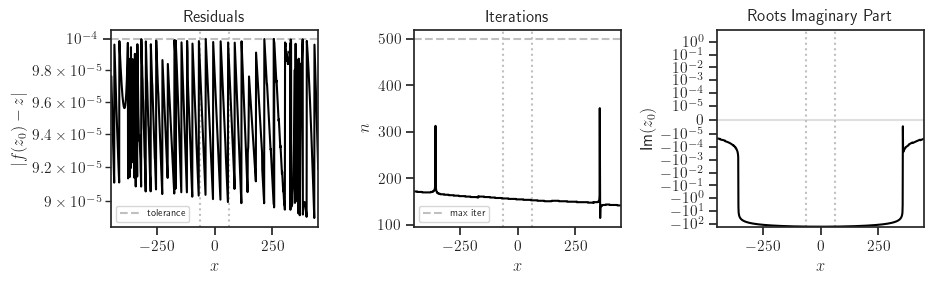

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_wg.pdf".


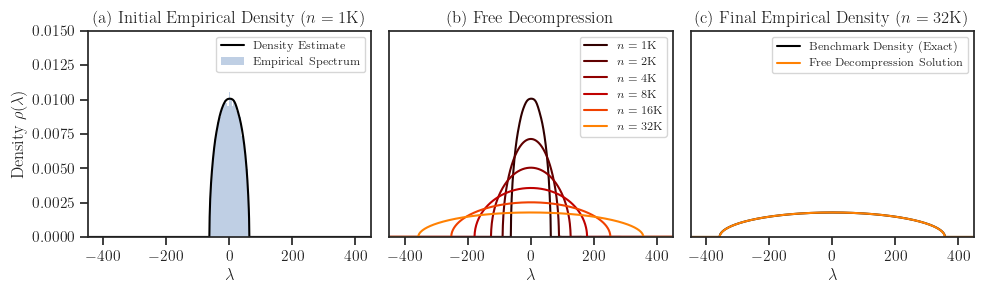

In [4]:
n = 1000
wg = Wigner(2 * numpy.sqrt(n))
A = wg.matrix(n, seed=0)
eig = np.linalg.eigvalsh(A)
#eig = mp.sample(1000)

ff = FreeForm(eig, support=(wg.lam_m, wg.lam_p))
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.01, damp='jackson',
             force=True, continuation='pade', pade_p=0, pade_q=1,
             odd_side='left', pade_reg=0, optimizer='ls',
             plot=True, latex=latex, save=False)

family = lambda n: Wigner(2 * numpy.sqrt(32000))
save_filename = 'flow_wg' + ext
ylim = [0, 0.015]
x = np.linspace(-450, 450, 1000)

with texplot.theme(use_latex=True):
    decompress_plot(eig, x, ff, family, save_filename, ylim=ylim)

### Wachter

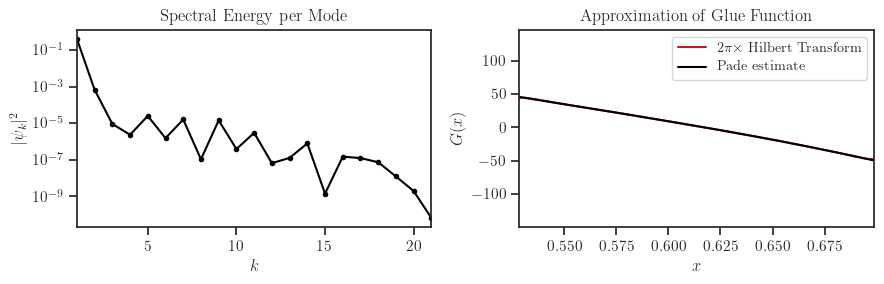

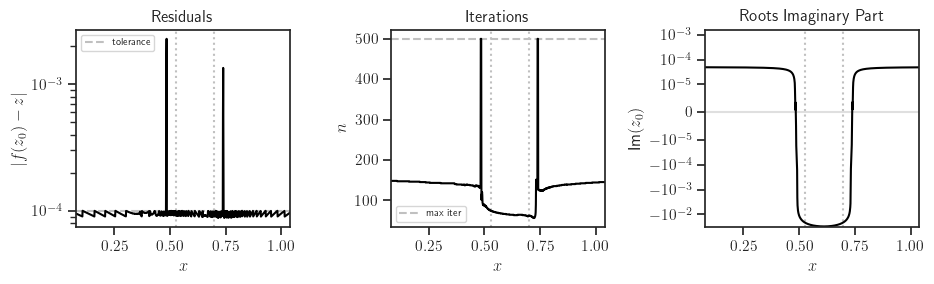

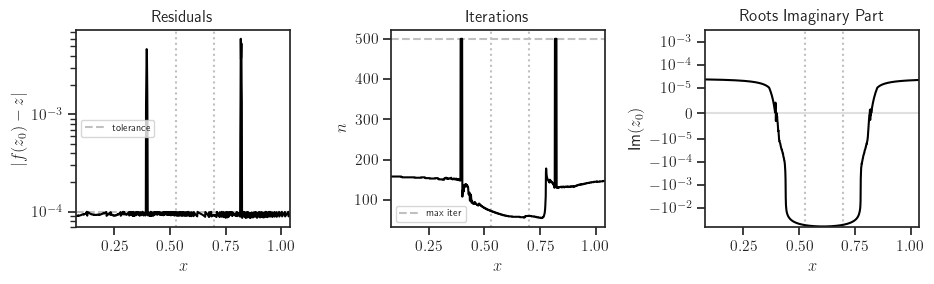

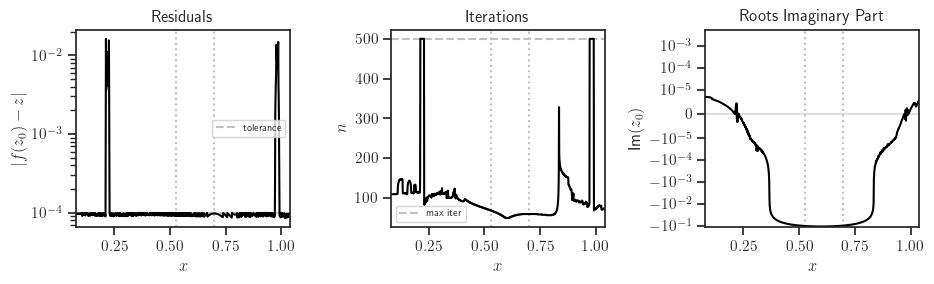

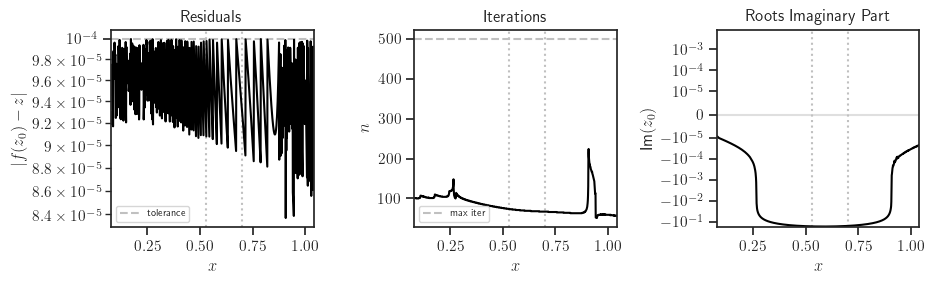

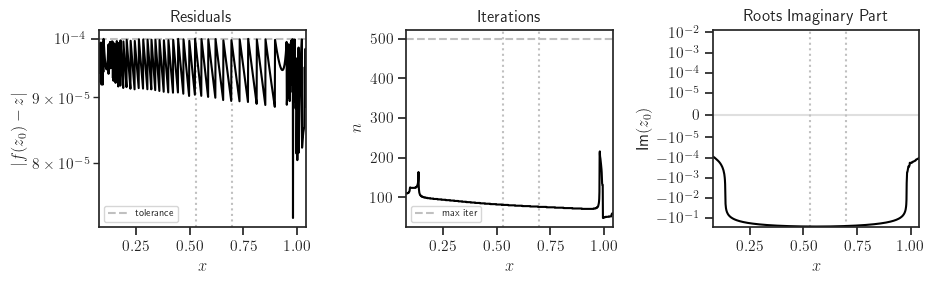

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_wa.pdf".


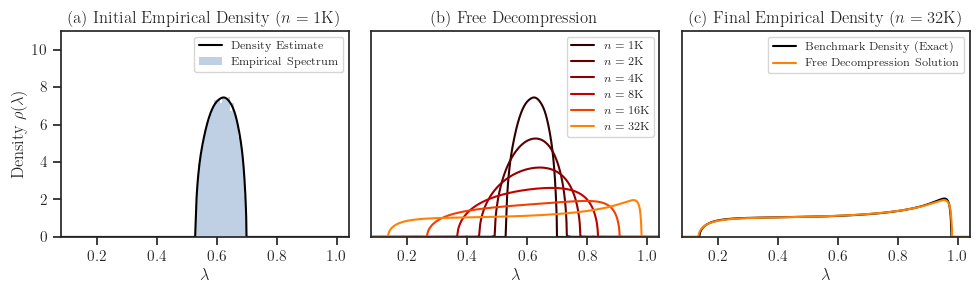

In [8]:
from scipy.linalg import eigh

n = 1000
a, b = 80, 50
wa = Wachter(a, b)
Sx, Sy = wa.matrix(n, seed=2)
eig = eigh(Sx, Sx+Sy, eigvals_only=True)
#eig = wa.sample(1000)

eps = 1e-4
ff = FreeForm(eig, support=(wa.lam_m-eps, wa.lam_p+eps), delta=1e-4)
psi = ff.fit(method = 'chebyshev', K=20, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, continuation='pade', pade_p=-1, pade_q=2,
             odd_side='left', pade_reg=0, optimizer='de',
             plot=True, latex=latex, save=False)

family = lambda n: Wachter(a/(n/1000), b/(n/1000))
save_filename = 'flow_wa' + ext
ylim = [0, 11]
x = np.linspace(0.08, 1.04, 1000)

with texplot.theme(use_latex=True):
    decompress_plot(eig, x, ff, family, save_filename, ylim=ylim)

### Kesten-McKay

In [6]:
n = 32_000
d = 2
km = KestenMcKay(d)
A = km.matrix(n, seed=0)
eig_all = np.linalg.eigvalsh(A)

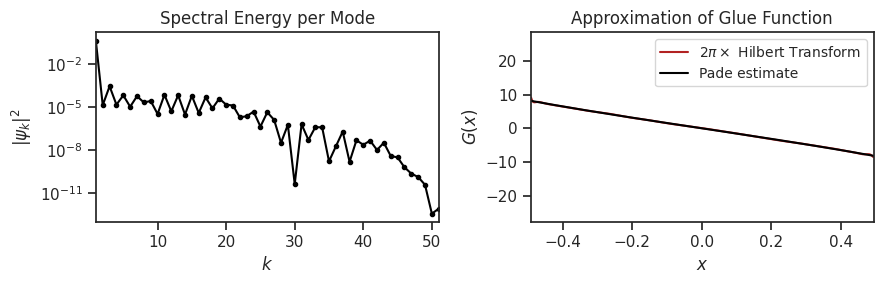

In [15]:
ns = 1000
eig = np.linalg.eigvalsh(A[:ns, :ns])

eps = 2.5e-3
ff = FreeForm(eig, support=(min(eig)-eps, max(eig)+eps), delta=1e-4)
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, pade_p=-1, pade_q=2, odd_side='left', pade_reg=0,
             optimizer='de', plot=True, latex=False, save=False)

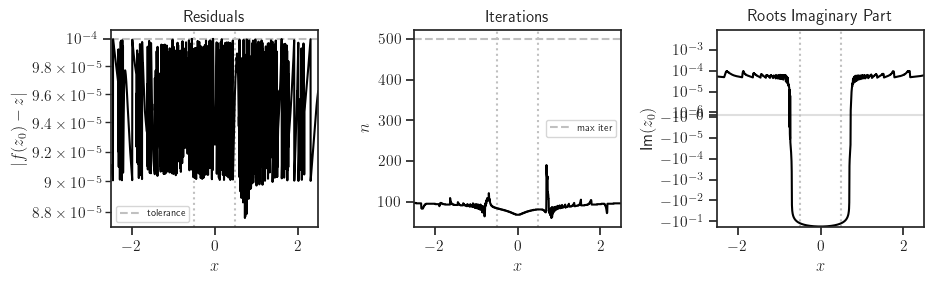

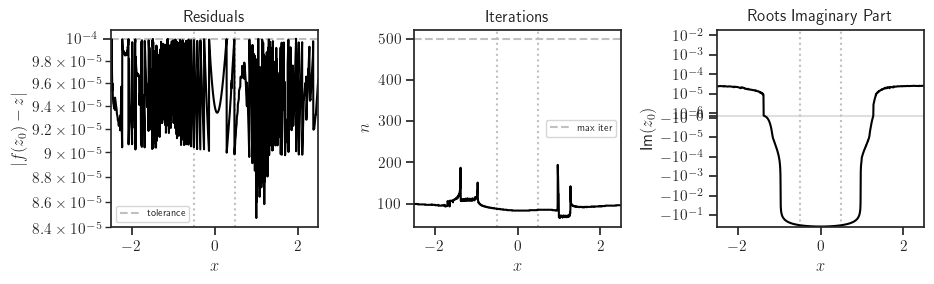

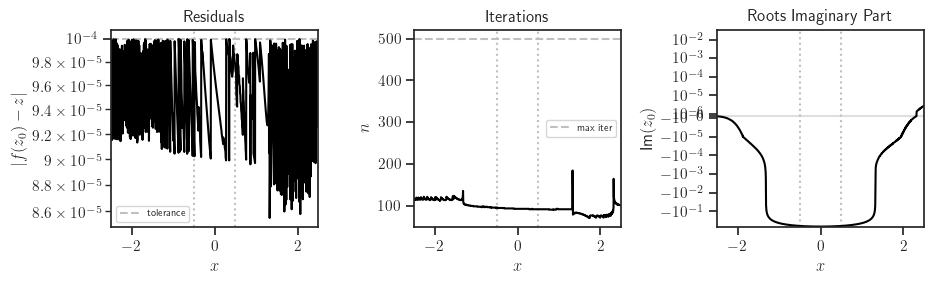

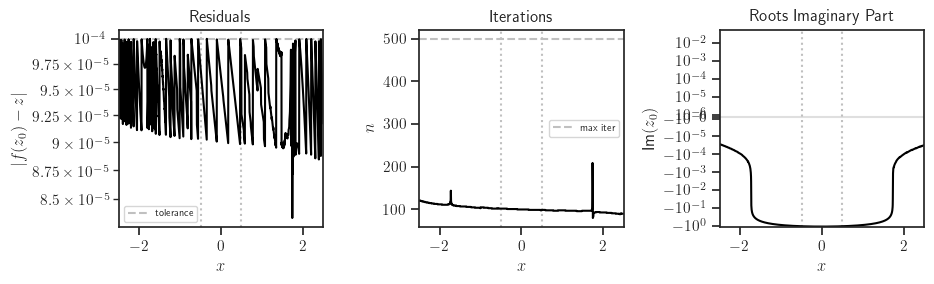

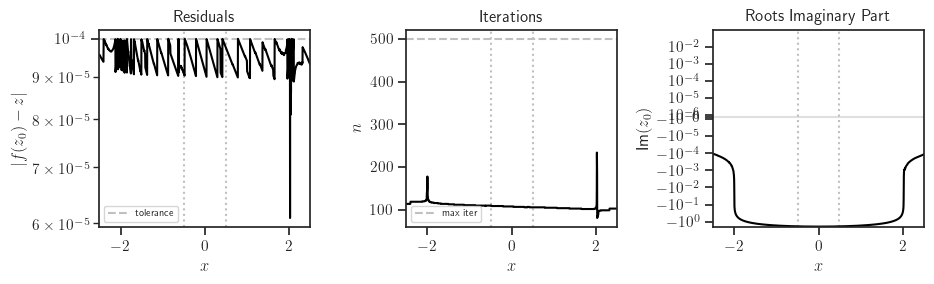

Plot saved to "/home/eecs/sameli/freealg/notebooks/flow_km.pdf".


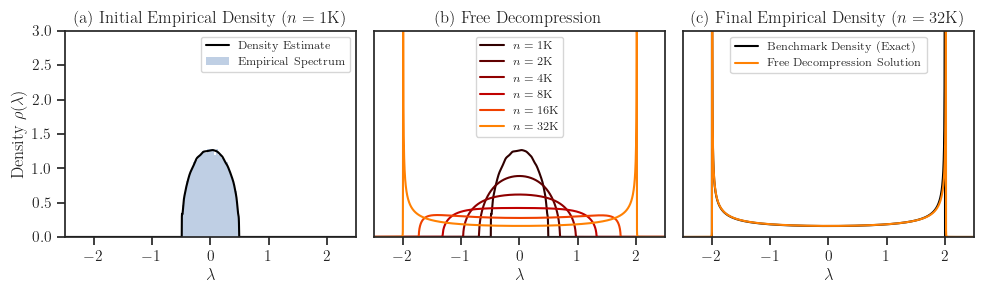

In [16]:
family = lambda n: KestenMcKay(d)
save_filename = 'flow_km'+ext
ylim = [0, 3]
x = np.linspace(-2.5, 2.5, 2000)

with texplot.theme(use_latex=True):
    decompress_plot(eig, x, ff, family, save_filename, ylim=ylim)

### Meixner

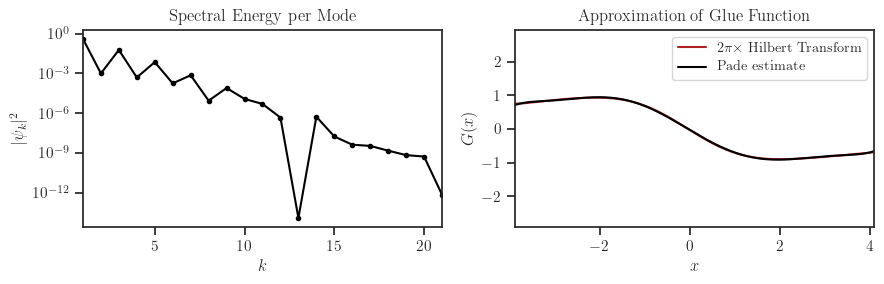

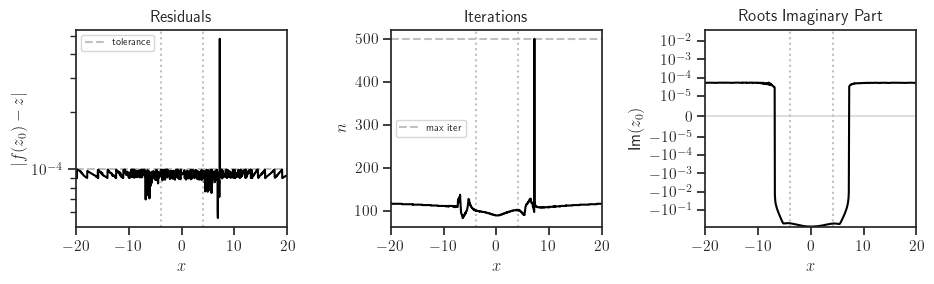

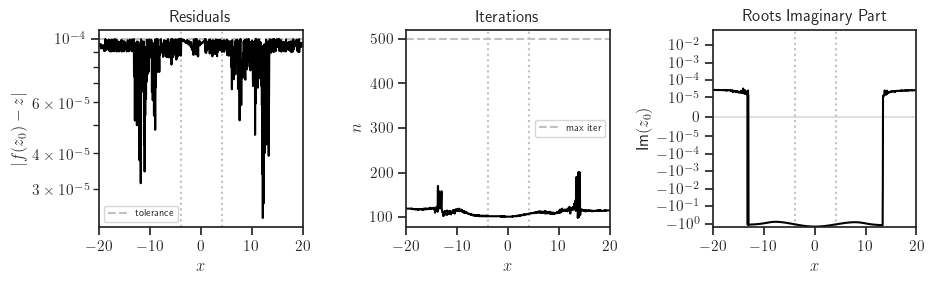

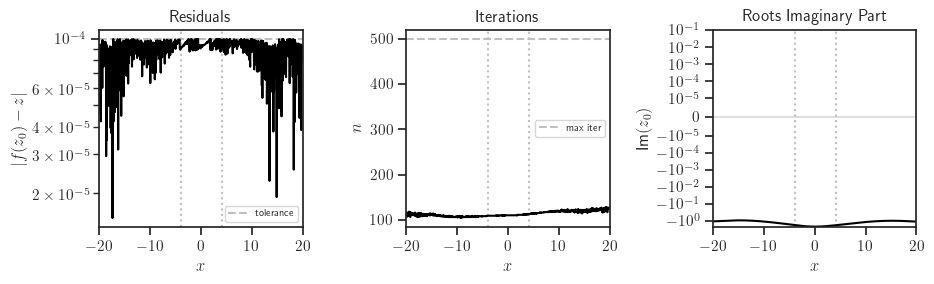

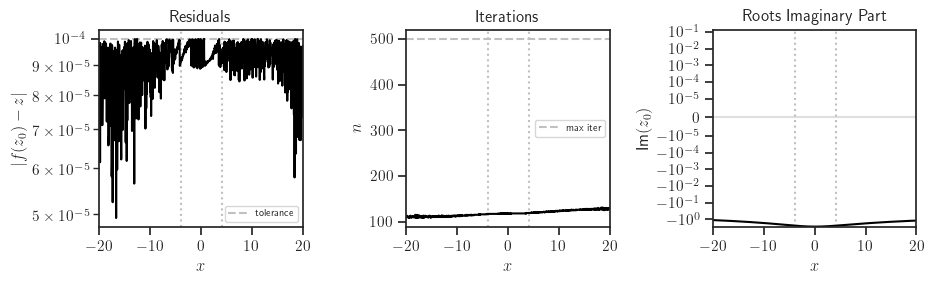

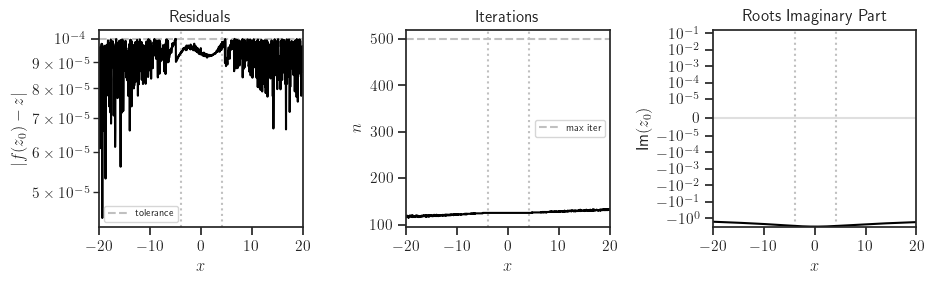

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_mx.pdf".


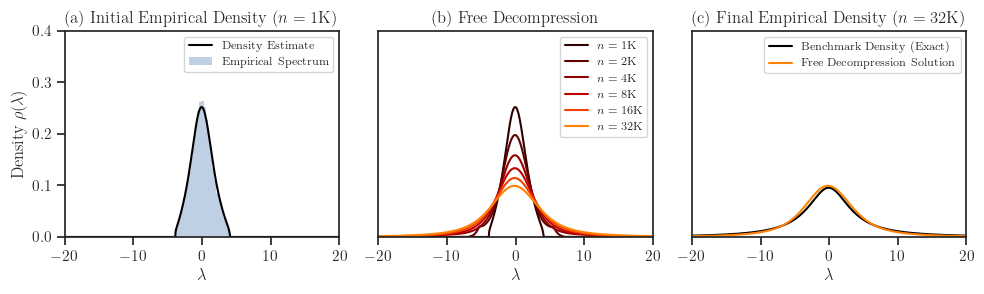

In [6]:
n = 1000
a, b, c = 0.1, 4, 0.6
mx = Meixner(a, b, c)
eig = mx.sample(n, seed=0)

ff = FreeForm(eig, support=(mx.lam_m, mx.lam_p), delta=1e-4)
psi = ff.fit(method = 'chebyshev', K=20, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, continuation='pade', pade_p=-1, pade_q=8,
             odd_side='left', pade_reg=0, optimizer='de',
             plot=True, latex=latex, save=False)

alpha = lambda n: (n/1000)**0.5
a_prime = lambda n: a * alpha(n)
c_prime = lambda n: c / (c + alpha(n)*(1-c))
b_prime = lambda n: b * alpha(n)**2 * (1 - c_prime(n)) / (1 - c)
family = lambda n: Meixner(a_prime(n), b_prime(n), c_prime(n))
save_filename = 'flow_mx' + ext
ylim = [0, .4]
x = np.linspace(-20, 20, 1000)
#cutoff = lambda n,x: x < 0.89+0.11*n/32000

with texplot.theme(use_latex=True):
    decompress_plot(eig, x, ff, family, save_filename, ylim=ylim)